In [1]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
import numpy as np
import matplotlib.pyplot as plt
from pymoo.indicators.hv import HV
from pymoo.problems import get_problem
from pymoo.util.dominator import Dominator
import cma
import json
from ipynb.fs.full.nds import fast_non_dominated_sort
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from scipy.optimize import differential_evolution
import sobol_seq
from scipy.stats import norm

In [2]:
def calculate_hv(PF,r):
#     hv = get_performance_indicator("hv", ref_point=r)
    ind = HV(ref_point=r)
    HV_PF = ind(PF)
    return HV_PF


In [3]:
def EHVI_2D(PF,r,mu,sigma):
    n = PF.shape[0]
    S1 = np.array([r[0],-np.inf])
    S1 = S1.reshape(1,-1)
    Send = np.array([-np.inf,r[1]])
    Send = Send.reshape(1,-1)
    index = np.argsort(PF[:,1])
    
    S = PF[index,:]
    
    S = np.concatenate((S1,S,Send),axis = 0)
    
    y1 = S[:,0] 
    y2 = S[:,1]
    
    y1 = y1.reshape(-1,1)
    y2 = y2.reshape(-1,1)
    
    mu = mu.reshape(1,-1)
    sigma = sigma.reshape(1,-1)
        
    sum_total1 = 0;
    sum_total2 = 0;
    
    for i in range(1,n+2):
        t = (y1[i] - mu[0][0])/sigma[0][0]
        if i==n+1:
            sum_total1 = sum_total1
        else:
            sum_total1 = sum_total1 + (y1[i-1] - y1[i])*stats.norm.cdf(t)*psi_cal(y2[i],y2[i],mu[0][1],sigma[0][1])
        sum_total2 = sum_total2 + (psi_cal(y1[i-1],y1[i-1],mu[0][0],sigma[0][0]) \
                                   - psi_cal(y1[i-1],y1[i],mu[0][0],sigma[0][0]))*psi_cal(y2[i],y2[i],mu[0][1],sigma[0][1])
        
    EHVI = sum_total1 + sum_total2
    return EHVI


def psi_cal(a,b,m,s):
    t = (b - m)/s
    return s*stats.norm.pdf(t) + (a - m)*stats.norm.cdf(t)

In [4]:
def sobol_multivariate_normal(mean, cov, n_samples, sobol_samples=None,norm_samples= None):
    """
    Draw or update Sobol samples for a multi-variate normal distribution.
    
    Parameters:
    - mean: Mean vector of the multi-variate normal distribution.
    - cov: Covariance matrix of the multi-variate normal distribution.
    - n_samples: Number of Sobol samples to generate.
    - sobol_samples: (Optional) Existing Sobol samples to transform.
    
    Returns:
    - samples: Sobol samples transformed to follow the multi-variate normal distribution.
    """
    dim = len(mean)
    
    if sobol_samples is None:
        # Generate Sobol samples in the unit hypercube
        sobol_samples = sobol_seq.i4_sobol_generate(dim, n_samples)
    
        # Transform Sobol samples to follow the standard normal distribution using the inverse CDF (quantile function)
        norm_samples = norm.ppf(sobol_samples)
    
    # Use the Cholesky decomposition to transform standard normal samples to the target multi-variate normal distribution
    L = np.linalg.cholesky(cov)
    samples = norm_samples @ L.T + mean
    
    return samples, sobol_samples

def EHVI_monte_carlo(PF,r,mu,sigma,HV_PF,sobol_samples,norm_samples):
    mu = mu.reshape(-1)
    sigma = sigma.reshape(-1)
    Sigma = np.diag(sigma**2)
#     samples = np.random.multivariate_normal(mean = mu,cov = Sigma,size=50000)
    samples,ss_samples = sobol_multivariate_normal(mu, Sigma, len(sobol_samples),sobol_samples,norm_samples)
    n_samples = samples.shape[0]
    HV_cont = np.zeros(n_samples);
    for i in range(0,n_samples):
        #print(i)
        s = samples[i,:]
        s = s.reshape(1,-1)
        PF_temp = np.concatenate((PF,s),axis=0)
        #print(PF_temp)
        front_index = fast_non_dominated_sort(PF_temp)
        #print(front_index[0])
        front_index = np.asarray(front_index[0])
        #print(front_index)
        PF_i = PF_temp[front_index,:]
        PF_i = PF_i.reshape(-1,F.shape[1])
        HV_cont[i] = calculate_hv(PF_i,r) - HV_PF

    return np.mean(HV_cont)

In [5]:
def AF(x,thisdict):    
    models = thisdict["models"]
    
    PF = thisdict["Pareto_front"]
    HV_PF = thisdict["HV_PF"]
    r = thisdict["ref_point"]
    sobol_samples = thisdict["random_samples"]
    norm_samples = thisdict["random_samples_norm"]
    
    
    x = x.reshape(1,-1)
    
    mu = np.zeros(PF.shape[1])
    sigma = np.zeros(PF.shape[1])
#     print(mu.shape)
    for k in range(PF.shape[1]):
        mu[k],sigma[k] = models[k].predict(x,return_std=True)
    
#     print(mu.shape, sigma.shape)
        
    mu = mu.reshape(1,-1)
    sigma = sigma.reshape(1,-1)
    
    if PF.shape[1]>2:
        return -EHVI_monte_carlo(PF,r,mu,sigma,HV_PF,sobol_samples,norm_samples)
    else:
        return -EHVI_2D(PF,r,mu,sigma)
    
    


In [6]:
no_var = 2
bounds = no_var*([(0,1)])
problem = get_problem('dtlz2',n_var=no_var,n_obj=3)
lb = np.zeros(no_var)
ub = np.ones(no_var)
X = lb + (ub - lb)*np.random.rand(10*no_var,no_var)
F = problem.evaluate(X) 
r = np.max(F,0)+ 2

lb = lb.reshape(1,-1)
ub = ub.reshape(1,-1)

n_samples = 100
sobol_samples = sobol_seq.i4_sobol_generate(F.shape[1], n_samples)
norm_samples = norm.ppf(sobol_samples)




# main loop
for i in range(0,2*no_var):
    # non dominated sorting
    print(i)
    front_index = fast_non_dominated_sort(F)
    front_index = np.asarray(front_index[0])
    PF = F[front_index,:]
    PF = PF.reshape(-1,F.shape[1])
    
    HV_PF = calculate_hv(PF,r)
    
    kernel = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-05, 100000.0),nu=2.5)
    
    # Modelling
    models = []
    for k in range(PF.shape[1]):
        model = GaussianProcessRegressor(kernel=kernel,alpha=1e-5,n_restarts_optimizer=10,normalize_y=True,optimizer='fmin_l_bfgs_b').fit(X, F[:,k])
        models.append(model)
        thisdict = {"models": models,"Pareto_front": PF,"HV_PF": HV_PF,"ref_point": r,"random_samples": sobol_samples,
               "random_samples_norm": norm_samples} 

#     x0 = np.random.rand(1,no_var)
#     x0 = x0.flatten()
#     opts = cma.CMAOptions()
    #opts.set("bounds", [lb, ub])
    
    
    #res = cma.fmin(maximise_AF, x0, 0.5, args=('m1','m2','PF','HV_PF','r',),restarts=0)
#     opts = cma.CMAOptions()
#     opts.set("bounds", [[0, 0], [1, 1]])
#     xopt,es = cma.fmin2(AF, x0, 0.5, opts,args=(thisdict,),restarts=1)
    
    results_optimiser = differential_evolution(AF, bounds,args = (thisdict,)) #optimiser
    xopt = results_optimiser.x
    fopt = problem.evaluate(xopt)

    xopt = xopt.reshape(1,-1)
    fopt = fopt.reshape(1,-1)

    X = np.concatenate((X,xopt),axis=0)
    F = np.concatenate((F,fopt),axis=0)


0
1
2
3


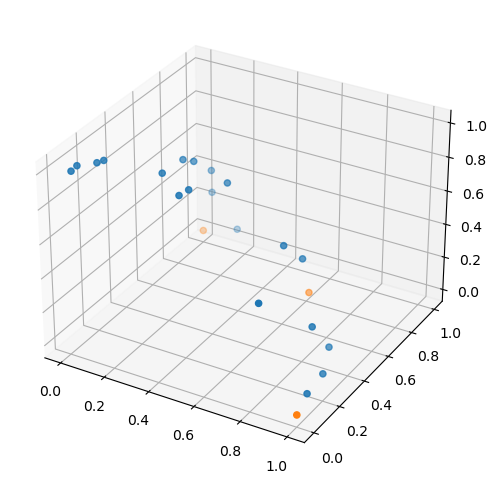

In [7]:
fig = plt.figure(figsize=(6, 6))

if F.shape[1]==2:
    ax = fig.subplots()
    ax.scatter(F[0:10*no_var,0],F[0:10*no_var,1],label = 'Initial samples')
    ax.scatter(F[10*no_var+1:,0],F[10*no_var+1:,1],label = 'BO samples')
    # plt.colorbar()
    plt.legend()
    plt.show()
    
elif F.shape[1]==3:
    ax = fig.add_subplot(projection='3d')
    ax.scatter(F[0:10*no_var,0],F[0:10*no_var,1],F[0:10*no_var,2],label = 'Initial samples')
    ax.scatter(F[10*no_var+1:,0],F[10*no_var+1:,1],F[10*no_var+1:,2],label = 'BO samples')
    plt.show()